# Forecasting Electricity Demand

## Motivation

On $3^{rd}$ April 2020, as Indians were entering the 3rd week of the first covid-19 lockdown, PM Narendra Modi took to social media and twitter asking citizens to switch of their lights and light diyas for 9 minutes at 9pm on $5^{th}$ April 2020, in order to show solidarity with the healthcare and the frontline workers. This was reiterated by hundreds of thousands of prominent persons and celebrities. A major proportion of the citizens of the country of 138 crore population were expected to be a part of it. This led to the fear of a major power grid faliure due to sudden drop and surge in demand. As a result the states had to scramble for preparation of the event, issuing detailed orders to prevent disruptions.

The above case is an example of how important it is to anticipate potential surges and drop in electricity consumption. A power faliure affects not only the production process and industries but also hospitals and other essential functions. Forecasting the demand for electricity is important in order to build enough capacity and prevent power faliures. This is because storing electricity is still expensive and thus it has to be generated as per demand. This forecasting can be in long run, short run or over a medium run period. I use ARMA model on yearly data from UK's electricity board for prediction of total electricity demanded. This analysis can be further extended to include other variables such as the price of electricity, production of the country, availability of fuel, and other social and demand related variables.

## Data

I take data from Digest of United Kingdom Energy Statistics(DUKES) dataset which contains data on fuel inputs, Supply, Avaliability and consumption, Electricity generated and supplied, capacity, margin and prices. On the demand side is further divided into domestic and industrial demand.

## Model

Bases on minimum AIC, I try to fit ARMA(1,5) and ARMA(1,1) models given by:

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ardl import ARDL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%matplotlib notebook

In [87]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 

    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

In [88]:
path = r"C:\Users\parik\Documents\Data sets\Time series course\sac_elect.csv"
df = pd.read_csv(path,index_col=0)
df.head()

,Electricity supplied(net),Purchases from other producers,Net imports,Electricity Available,Losses in transmission,Total loss,Fuel industries,Industrial,Domestic,Other,Total
Year,,,,,,,,,,,
1920,3.976,0.089,0.0,4.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1921,3.605,0.059,0.0,3.664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922,4.226,0.150,0.0,4.376,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1923,4.928,0.249,0.0,5.177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1924,5.627,0.272,0.0,5.899,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preliminary Analysis

### We try to model the total electricity demand since 1970

<IPython.core.display.Javascript object>


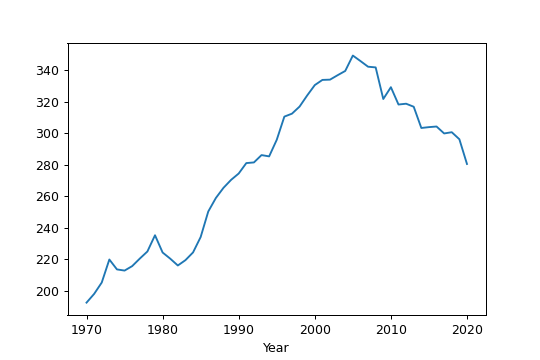

In [89]:
exog = df['Total'][50:].plot()

Taking first difference, we get

<IPython.core.display.Javascript object>


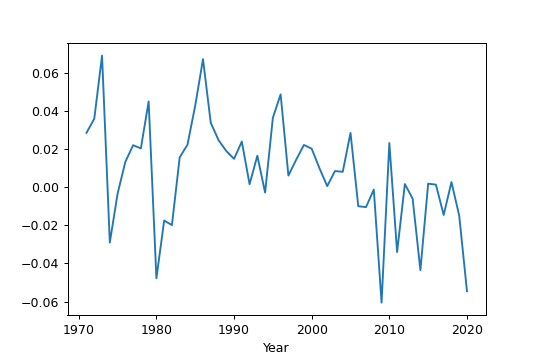

<AxesSubplot:xlabel='Year'>

In [90]:
plt.figure()
exog = np.log(df['Total'][50:]).diff(1)[1:]
exog.plot()

<IPython.core.display.Javascript object>


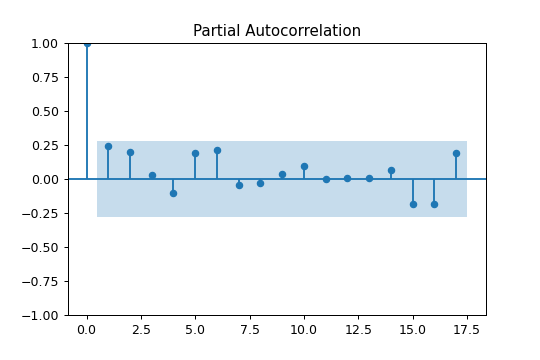

<IPython.core.display.Javascript object>


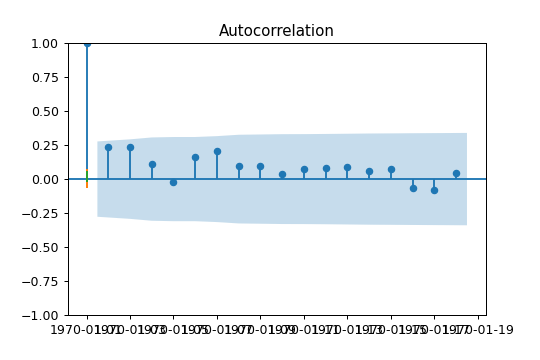

In [91]:
plot_pacf(exog);
plot_acf(exog);

In [93]:
ad_fuller_result = adfuller(exog)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.047705456295545
p-value: 0.030673152466244902


In [94]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### Choose model based on minimum aic criterion

In [95]:
ps = range(0, 8, 1)
d = 0
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(0, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=exog)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(1, 0, 1)",-216.617195
1,"(1, 0, 5)",-215.058841
2,"(1, 0, 0)",-214.799224
3,"(1, 0, 2)",-214.401045
4,"(1, 0, 3)",-212.240903
...,...,...
59,"(1, 6, 1)",0.587129
60,"(1, 7, 2)",11.378401
61,"(1, 6, 0)",45.512645
62,"(1, 7, 1)",53.016293


We model ARMA(1,5) and ARMA(1,1)

## Estimating ARMA(1,5)

In [96]:
ma_1 = ARIMA(exog, order=(1,0,5)).fit()
print(ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   50
Model:                 ARIMA(1, 0, 5)   Log Likelihood                 114.646
Date:                Tue, 03 May 2022   AIC                           -213.291
Time:                        12:13:42   BIC                           -197.995
Sample:                             0   HQIC                          -207.466
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.012      0.509      0.610      -0.018       0.030
ar.L1          0.8913      0.207      4.299      0.000       0.485       1.298
ma.L1         -0.7377      0.232     -3.185      0.0

Coefficients are not significant after the 2nd lag

## Estimating ARMA(1,1)

In [97]:
arma_11 = ARIMA(exog, order=(1,0,1)).fit()
print(arma_11.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   50
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 111.474
Date:                Tue, 03 May 2022   AIC                           -214.947
Time:                        12:13:42   BIC                           -207.299
Sample:                             0   HQIC                          -212.035
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.011      0.577      0.564      -0.015       0.027
ar.L1          0.9041      0.189      4.783      0.000       0.534       1.274
ma.L1         -0.7313      0.268     -2.726      0.0

We can see that ARMA(1,1) has minimum aic and the coefficients are also significant.

Going further we can see that we can further improve the model by incorporating breaks.

# Incorporating Breaks

In [100]:
df.index = pd.to_datetime(df.index)

In [101]:
df['ts_dummy'] = df.index> pd.to_datetime("01-01-2005")

In [102]:
df['ts_dummy'] = df['ts_dummy'].astype(int)

In [103]:
df['ts_dummy'].shape

(101,)

### Trend Break Dummy

In [104]:
lnTotal = np.log(df['Total'])[49:]

In [105]:
endog = lnTotal.diff(1)[1:]
exog = df['ts_dummy'].values

In [106]:
exog = exog[50:]

In [107]:
lnTotal.shape,exog.shape

((52,), (51,))

In [108]:
endog.shape,exog.shape

((51,), (51,))

In [109]:
arma_11_ts = SARIMAX(endog = endog,exog =exog,  order=(1,1,1)).fit()
print(arma_11_ts.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 110.369
Date:                Tue, 03 May 2022   AIC                           -212.738
Time:                        12:14:47   BIC                           -205.090
Sample:                    01-01-1970   HQIC                          -209.825
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0         -0        nan        nan           0           0
ar.L1          0.0580      0.182      0.319      0.750      -0.298       0.414
ma.L1         -0.8175      0.136     -6.019      0.0

In [82]:
exog = df['ts_dummy'].values

In [110]:
len(exog)

51

In [111]:
forecast = arma_11_ts.predict(start=0, end=50,exog=exog)

<IPython.core.display.Javascript object>


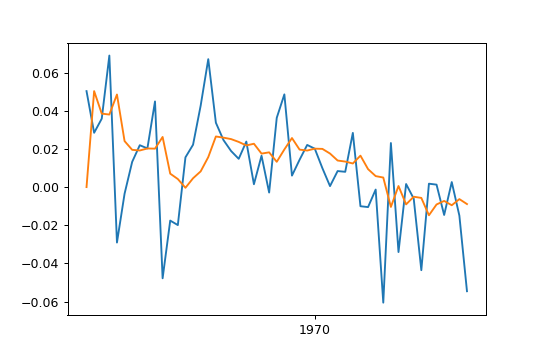

In [113]:
plt.figure()
plt.plot(endog)
plt.plot(forecast)

# Incorporating industrial production

Next we try to see if the fall in the electricity demand in uk could be because of the change in trend of industrial production. Most of the electricity demand comes from industrial activity. A fall in industrial activity could explain some of the fall in the demand.

In [3]:
ind_prod = pd.read_csv('industrial production uk.csv',index_col=0)

<IPython.core.display.Javascript object>


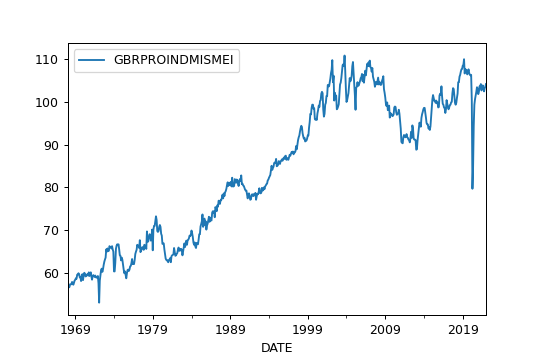

<AxesSubplot:xlabel='DATE'>

In [48]:
ind_prod.plot()

Note that around the same time that there is a fall in electricity demand. Industrial activity also falls. Could this explain the fall former?

In [4]:
ind_prod.index = pd.to_datetime(ind_prod.index)

In [5]:
df.index = pd.to_datetime(df.index, format = "%Y")

In [6]:
df = df[df.index >= pd.to_datetime('01-01-1970')]

<IPython.core.display.Javascript object>


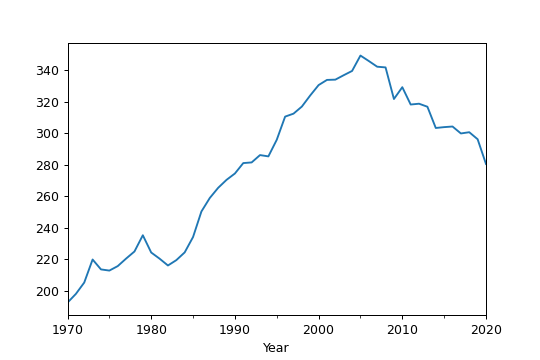

<AxesSubplot:xlabel='Year'>

In [12]:
df.Total.plot()

In [14]:
ip_yearly = ind_prod.resample('Y').sum()

In [15]:
ip_yearly = ip_yearly[ip_yearly.index>=pd.to_datetime('01-01-1970')]

In [16]:
len(ip_yearly)

53

In [17]:
len(df)

51

In [18]:
df.tail()

,Electricity supplied(net),Purchases from other producers,Net imports,Electricity Available,Losses in transmission,Total loss,Fuel industries,Industrial,Domestic,Other,Total
Year,,,,,,,,,,,
2016-01-01,319.88,0.0,17.75,337.63,26.33,311.30,7.02,93.56,108.03,102.69,304.28
2017-01-01,318.87,0.0,14.76,333.63,26.83,306.79,6.92,92.53,105.37,101.97,299.87
2018-01-01,313.92,0.0,19.11,333.03,25.65,307.37,6.71,94.09,105.06,101.51,300.66
2019-01-01,307.03,0.0,21.17,328.20,25.45,302.75,6.54,92.43,103.82,99.95,296.20
2020-01-01,295.81,0.0,17.91,313.72,26.31,287.42,6.94,83.89,107.85,88.74,280.48


In [19]:
ip_yearly = ip_yearly[ip_yearly.index <= pd.to_datetime('01-01-2021')]

In [20]:
len(ip_yearly)

51

In [21]:
df['ip'] = ip_yearly.values

In [22]:
df.head()

,Electricity supplied(net),Purchases from other producers,Net imports,Electricity Available,Losses in transmission,Total loss,Fuel industries,Industrial,Domestic,Other,Total,ip
Year,,,,,,,,,,,,
1970-01-01,215.76,0.19,0.55,216.50,17.50,199.00,6.59,72.99,77.04,42.38,192.41,713.676286
1971-01-01,222.92,0.53,0.12,223.57,19.01,204.56,6.60,73.43,80.67,43.86,197.96,710.019717
1972-01-01,229.45,0.53,0.48,230.46,18.91,211.55,6.37,73.16,86.89,45.13,205.18,722.064886
1973-01-01,245.42,0.59,0.06,246.07,19.59,226.48,6.67,80.07,91.30,48.44,219.81,787.130310
1974-01-01,237.21,0.60,0.05,237.86,18.22,219.64,6.12,75.81,92.63,45.08,213.52,771.321025


<IPython.core.display.Javascript object>


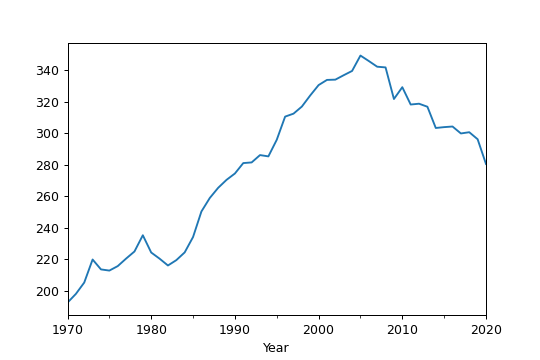

<AxesSubplot:xlabel='Year'>

In [44]:
df.Total.plot()

<IPython.core.display.Javascript object>


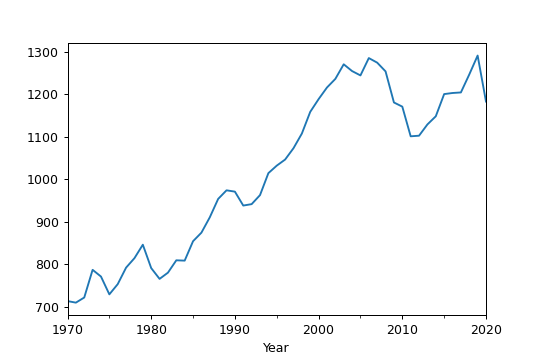

<AxesSubplot:xlabel='Year'>

In [45]:
df.ip.plot()

In [24]:
df['d_Total'] = df.Total.diff()

In [25]:
df['d_ip'] = df.ip.diff()

In [26]:
df.head()

,Electricity supplied(net),Purchases from other producers,Net imports,Electricity Available,Losses in transmission,Total loss,Fuel industries,Industrial,Domestic,Other,Total,ip,d_Total,d_ip
Year,,,,,,,,,,,,,,
1970-01-01,215.76,0.19,0.55,216.50,17.50,199.00,6.59,72.99,77.04,42.38,192.41,713.676286,NaN,NaN
1971-01-01,222.92,0.53,0.12,223.57,19.01,204.56,6.60,73.43,80.67,43.86,197.96,710.019717,5.55,-3.656569
1972-01-01,229.45,0.53,0.48,230.46,18.91,211.55,6.37,73.16,86.89,45.13,205.18,722.064886,7.22,12.045169
1973-01-01,245.42,0.59,0.06,246.07,19.59,226.48,6.67,80.07,91.30,48.44,219.81,787.130310,14.63,65.065424
1974-01-01,237.21,0.60,0.05,237.86,18.22,219.64,6.12,75.81,92.63,45.08,213.52,771.321025,-6.29,-15.809285


In [27]:
ad_fuller_result = adfuller(df.d_Total[1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.845219983504995
p-value: 0.05209908500487752


In [35]:
ad_fuller_result = adfuller(df.d_ip[1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.874148943672916
p-value: 3.914842811170189e-05


In both cases the pvalue is small indicating that both the series are stationary

In [36]:
endog = df.d_Total[1:].values
exog = df.d_ip[1:].values

In [37]:
endog.shape

(50,)

In [38]:
exog.shape

(50,)

In [43]:
mod_L4_est = smf.ols(formula = 'd_Total ~ 1 + lag(d_Total,1) + lag(d_ip, 0) + lag(d_ip, 1) + lag(d_ip, 2) + lag(d_ip, 3) + lag(d_ip, 4)', data = df)
mod_L4_fit = mod_L4_est.fit()
print(mod_L4_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                d_Total   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     4.520
Date:                Tue, 03 May 2022   Prob (F-statistic):            0.00144
Time:                        11:33:17   Log-Likelihood:                -144.82
No. Observations:                  46   AIC:                             303.6
Df Residuals:                      39   BIC:                             316.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.2852      1.063     

In [46]:
mod_L4_est = smf.ols(formula = 'd_Total ~ 1 + lag(d_Total,1) + lag(d_ip, 0) + lag(d_ip, 1) + lag(d_ip, 2)', data = df)
mod_L4_fit = mod_L4_est.fit()
print(mod_L4_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                d_Total   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     8.359
Date:                Tue, 03 May 2022   Prob (F-statistic):           4.42e-05
Time:                        11:34:59   Log-Likelihood:                -151.12
No. Observations:                  48   AIC:                             312.2
Df Residuals:                      43   BIC:                             321.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.2403      0.971     

In [47]:
mod_L4_est = smf.ols(formula = 'd_Total ~ 1 + lag(d_Total,1) + lag(d_ip, 0) + lag(d_ip, 2)', data = df)
mod_L4_fit = mod_L4_est.fit()
print(mod_L4_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                d_Total   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     10.52
Date:                Tue, 03 May 2022   Prob (F-statistic):           2.45e-05
Time:                        11:35:26   Log-Likelihood:                -151.95
No. Observations:                  48   AIC:                             311.9
Df Residuals:                      44   BIC:                             319.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.4256      0.965     